# GAN on Harmful Behavior

In [1]:
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.utils as vutils
import matplotlib.pyplot as plt

In [2]:
from datasets.behavior import *

In [30]:
CUDA = False
DATA_PATH = './data'
BATCH_SIZE = 1
IMAGE_CHANNEL = 1
Z_DIM = 8
G_HIDDEN = 64
X_DIM = 64
D_HIDDEN = 64
REAL_LABEL = 1
FAKE_LABEL = 0
lr = 2e-4
seed = 1

In [31]:
CUDA = CUDA and torch.cuda.is_available()
print("PyTorch version: {}".format(torch.__version__))
if CUDA:
    print("CUDA version: {}\n".format(torch.version.cuda))

if CUDA:
    torch.cuda.manual_seed(seed)
device = torch.device("cuda:0" if CUDA else "cpu")
cudnn.benchmark = True

PyTorch version: 1.12.1


In [32]:
# Data preprocessing
dataset = BehaviourDataset('./behavior.csv', harmful_only=True)

# Dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=2)

In [33]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

### Generator and Discriminator

In [48]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            torch.nn.Linear(Z_DIM, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 105),
        )

    def forward(self, input):
        return self.main(input)

In [49]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            torch.nn.Linear(105, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 32),
            torch.nn.Linear(32, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 1),
            torch.nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

In [50]:
# Create the generator
netG = Generator().to(device)
netG.apply(weights_init)
print(netG)

# Create the discriminator
netD = Discriminator().to(device)
netD.apply(weights_init)
print(netD)

Generator(
  (main): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=105, bias=True)
  )
)
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=105, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Linear(in_features=16, out_features=1, bias=True)
    (6): Sigmoid()
  )
)


In [56]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that I will use to visualize the progression of the generator
viz_noise = torch.randn(BATCH_SIZE, 1, 1, Z_DIM, device=device)

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

In [57]:
EPOCH_NUM = 20

In [58]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(EPOCH_NUM):
    for i, data in enumerate(dataloader, 0):
        # (1) Update the discriminator with real data
        netG.train(True)
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), REAL_LABEL, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        # (2) Update the discriminator with fake data
        # Generate batch of latent vectors
        noise = torch.randn(b_size, 1, 1, Z_DIM, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(FAKE_LABEL)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        # (3) Update the generator with fake data
        netG.zero_grad()
        label.fill_(REAL_LABEL)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, EPOCH_NUM, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        iters += 1
        
        netG.train(False)
        with torch.no_grad():
            fake = netG(viz_noise).detach().cpu()
        img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

Starting Training Loop...
[0/20][0/26878]	Loss_D: 1.3786	Loss_G: 0.6797	D(x): 0.5112	D(G(z)): 0.5072 / 0.5068
[0/20][50/26878]	Loss_D: 1.3679	Loss_G: 0.7036	D(x): 0.5045	D(G(z)): 0.4953 / 0.4948
[0/20][100/26878]	Loss_D: 1.3768	Loss_G: 0.6939	D(x): 0.5056	D(G(z)): 0.5008 / 0.4996
[0/20][150/26878]	Loss_D: 1.3999	Loss_G: 0.6851	D(x): 0.4982	D(G(z)): 0.5050 / 0.5040
[0/20][200/26878]	Loss_D: 1.3900	Loss_G: 0.6977	D(x): 0.4973	D(G(z)): 0.4992 / 0.4977
[0/20][250/26878]	Loss_D: 1.3800	Loss_G: 0.6948	D(x): 0.5028	D(G(z)): 0.4997 / 0.4992
[0/20][300/26878]	Loss_D: 1.3779	Loss_G: 0.6995	D(x): 0.5016	D(G(z)): 0.4974 / 0.4968
[0/20][350/26878]	Loss_D: 1.4026	Loss_G: 0.6871	D(x): 0.4956	D(G(z)): 0.5037 / 0.5030
[0/20][400/26878]	Loss_D: 1.3869	Loss_G: 0.6987	D(x): 0.4972	D(G(z)): 0.4975 / 0.4972
[0/20][450/26878]	Loss_D: 1.3654	Loss_G: 0.7195	D(x): 0.4988	D(G(z)): 0.4882 / 0.4870
[0/20][500/26878]	Loss_D: 1.3214	Loss_G: 0.7070	D(x): 0.5273	D(G(z)): 0.4941 / 0.4931
[0/20][550/26878]	Loss_D: 1.368

[0/20][4750/26878]	Loss_D: 1.6033	Loss_G: 0.8021	D(x): 0.3647	D(G(z)): 0.4482 / 0.4484
[0/20][4800/26878]	Loss_D: 1.4722	Loss_G: 0.8033	D(x): 0.4154	D(G(z)): 0.4478 / 0.4479
[0/20][4850/26878]	Loss_D: 1.4056	Loss_G: 0.8039	D(x): 0.4441	D(G(z)): 0.4478 / 0.4476
[0/20][4900/26878]	Loss_D: 1.4796	Loss_G: 0.8064	D(x): 0.4113	D(G(z)): 0.4463 / 0.4464
[0/20][4950/26878]	Loss_D: 1.4371	Loss_G: 0.7935	D(x): 0.4538	D(G(z)): 0.4764 / 0.4523
[0/20][5000/26878]	Loss_D: 0.9218	Loss_G: 0.7987	D(x): 0.8949	D(G(z)): 0.5555 / 0.4499
[0/20][5050/26878]	Loss_D: 1.4600	Loss_G: 0.7955	D(x): 0.4234	D(G(z)): 0.4515 / 0.4513
[0/20][5100/26878]	Loss_D: 1.3775	Loss_G: 0.7984	D(x): 0.4585	D(G(z)): 0.4500 / 0.4500
[0/20][5150/26878]	Loss_D: 1.3767	Loss_G: 0.8023	D(x): 0.4585	D(G(z)): 0.4494 / 0.4483
[0/20][5200/26878]	Loss_D: 1.3758	Loss_G: 0.8033	D(x): 0.4579	D(G(z)): 0.4482 / 0.4479
[0/20][5250/26878]	Loss_D: 0.6380	Loss_G: 0.7964	D(x): 0.9638	D(G(z)): 0.4518 / 0.4510
[0/20][5300/26878]	Loss_D: 0.8991	Loss_G: 0

[0/20][9500/26878]	Loss_D: 1.2726	Loss_G: 1.0031	D(x): 0.4435	D(G(z)): 0.3685 / 0.3667
[0/20][9550/26878]	Loss_D: 1.3774	Loss_G: 0.8502	D(x): 0.4408	D(G(z)): 0.4278 / 0.4273
[0/20][9600/26878]	Loss_D: 1.2948	Loss_G: 0.7955	D(x): 0.4995	D(G(z)): 0.4516 / 0.4514
[0/20][9650/26878]	Loss_D: 1.3915	Loss_G: 0.8007	D(x): 0.4515	D(G(z)): 0.4492 / 0.4490
[0/20][9700/26878]	Loss_D: 1.4039	Loss_G: 0.7869	D(x): 0.4510	D(G(z)): 0.4553 / 0.4553
[0/20][9750/26878]	Loss_D: 1.3912	Loss_G: 0.7878	D(x): 0.4566	D(G(z)): 0.4551 / 0.4548
[0/20][9800/26878]	Loss_D: 1.3899	Loss_G: 0.7899	D(x): 0.4564	D(G(z)): 0.4542 / 0.4539
[0/20][9850/26878]	Loss_D: 1.4161	Loss_G: 0.7851	D(x): 0.4462	D(G(z)): 0.4562 / 0.4561
[0/20][9900/26878]	Loss_D: 1.2248	Loss_G: 0.7775	D(x): 0.5436	D(G(z)): 0.4595 / 0.4596
[0/20][9950/26878]	Loss_D: 1.2704	Loss_G: 0.7342	D(x): 0.5829	D(G(z)): 0.5184 / 0.4799
[0/20][10000/26878]	Loss_D: 0.9280	Loss_G: 0.9774	D(x): 0.6883	D(G(z)): 0.4256 / 0.3763
[0/20][10050/26878]	Loss_D: 1.2494	Loss_G:

[0/20][14250/26878]	Loss_D: 1.4447	Loss_G: 0.9535	D(x): 0.3841	D(G(z)): 0.3861 / 0.3854
[0/20][14300/26878]	Loss_D: 0.5168	Loss_G: 0.9478	D(x): 0.9753	D(G(z)): 0.3885 / 0.3876
[0/20][14350/26878]	Loss_D: 1.4281	Loss_G: 0.9312	D(x): 0.3959	D(G(z)): 0.3944 / 0.3941
[0/20][14400/26878]	Loss_D: 1.4380	Loss_G: 0.9350	D(x): 0.3938	D(G(z)): 0.3972 / 0.3926
[0/20][14450/26878]	Loss_D: 0.7506	Loss_G: 0.9271	D(x): 0.7817	D(G(z)): 0.3961 / 0.3957
[0/20][14500/26878]	Loss_D: 1.4232	Loss_G: 0.9138	D(x): 0.4023	D(G(z)): 0.4011 / 0.4010
[0/20][14550/26878]	Loss_D: 1.2513	Loss_G: 0.8327	D(x): 0.5308	D(G(z)): 0.4610 / 0.4349
[0/20][14600/26878]	Loss_D: 0.4298	Loss_G: 1.1261	D(x): 0.9642	D(G(z)): 0.3252 / 0.3243
[0/20][14650/26878]	Loss_D: 1.3922	Loss_G: 0.8466	D(x): 0.5292	D(G(z)): 0.5304 / 0.4289
[0/20][14700/26878]	Loss_D: 0.5356	Loss_G: 0.9747	D(x): 0.9874	D(G(z)): 0.4072 / 0.3773
[0/20][14750/26878]	Loss_D: 0.9780	Loss_G: 0.9227	D(x): 0.6259	D(G(z)): 0.3992 / 0.3975
[0/20][14800/26878]	Loss_D: 1.71

[0/20][18950/26878]	Loss_D: 0.5918	Loss_G: 0.8802	D(x): 0.9480	D(G(z)): 0.4163 / 0.4147
[0/20][19000/26878]	Loss_D: 1.5153	Loss_G: 0.8498	D(x): 0.3844	D(G(z)): 0.4283 / 0.4275
[0/20][19050/26878]	Loss_D: 1.5959	Loss_G: 1.0973	D(x): 0.3041	D(G(z)): 0.3333 / 0.3338
[0/20][19100/26878]	Loss_D: 1.4263	Loss_G: 0.8242	D(x): 0.4280	D(G(z)): 0.4388 / 0.4386
[0/20][19150/26878]	Loss_D: 0.5597	Loss_G: 0.8696	D(x): 0.9855	D(G(z)): 0.4202 / 0.4191
[0/20][19200/26878]	Loss_D: 1.4329	Loss_G: 0.8288	D(x): 0.4237	D(G(z)): 0.4368 / 0.4366
[0/20][19250/26878]	Loss_D: 1.4343	Loss_G: 0.8527	D(x): 0.4154	D(G(z)): 0.4264 / 0.4263
[0/20][19300/26878]	Loss_D: 1.4542	Loss_G: 0.8489	D(x): 0.4083	D(G(z)): 0.4279 / 0.4279
[0/20][19350/26878]	Loss_D: 1.4946	Loss_G: 0.8622	D(x): 0.3882	D(G(z)): 0.4221 / 0.4222
[0/20][19400/26878]	Loss_D: 0.5336	Loss_G: 0.8853	D(x): 1.0000	D(G(z)): 0.4135 / 0.4126
[0/20][19450/26878]	Loss_D: 1.4175	Loss_G: 0.8879	D(x): 0.4121	D(G(z)): 0.4120 / 0.4115
[0/20][19500/26878]	Loss_D: 1.41

[0/20][23700/26878]	Loss_D: 0.8505	Loss_G: 0.8524	D(x): 0.7492	D(G(z)): 0.4298 / 0.4264
[0/20][23750/26878]	Loss_D: 0.9386	Loss_G: 0.8782	D(x): 0.6712	D(G(z)): 0.4172 / 0.4155
[0/20][23800/26878]	Loss_D: 1.2547	Loss_G: 0.8974	D(x): 0.4825	D(G(z)): 0.4090 / 0.4076
[0/20][23850/26878]	Loss_D: 0.5360	Loss_G: 0.8912	D(x): 0.9995	D(G(z)): 0.4147 / 0.4102
[0/20][23900/26878]	Loss_D: 0.7597	Loss_G: 0.9242	D(x): 0.7985	D(G(z)): 0.4141 / 0.3969
[0/20][23950/26878]	Loss_D: 0.4783	Loss_G: 0.9751	D(x): 0.9997	D(G(z)): 0.3799 / 0.3772
[0/20][24000/26878]	Loss_D: 0.7603	Loss_G: 0.7553	D(x): 0.8927	D(G(z)): 0.4763 / 0.4698
[0/20][24050/26878]	Loss_D: 1.4058	Loss_G: 0.8800	D(x): 0.4217	D(G(z)): 0.4187 / 0.4148
[0/20][24100/26878]	Loss_D: 0.4750	Loss_G: 1.0040	D(x): 0.9880	D(G(z)): 0.3705 / 0.3664
[0/20][24150/26878]	Loss_D: 1.3463	Loss_G: 1.0654	D(x): 0.3976	D(G(z)): 0.3456 / 0.3446
[0/20][24200/26878]	Loss_D: 0.4913	Loss_G: 1.0698	D(x): 0.9351	D(G(z)): 0.3457 / 0.3431
[0/20][24250/26878]	Loss_D: 0.96

[1/20][1500/26878]	Loss_D: 1.0911	Loss_G: 0.9650	D(x): 0.5500	D(G(z)): 0.3894 / 0.3810
[1/20][1550/26878]	Loss_D: 1.1378	Loss_G: 0.9010	D(x): 0.5446	D(G(z)): 0.4114 / 0.4061
[1/20][1600/26878]	Loss_D: 1.3779	Loss_G: 0.9218	D(x): 0.4245	D(G(z)): 0.4061 / 0.3978
[1/20][1650/26878]	Loss_D: 0.7079	Loss_G: 1.0005	D(x): 0.7874	D(G(z)): 0.3743 / 0.3677
[1/20][1700/26878]	Loss_D: 1.1777	Loss_G: 1.8163	D(x): 0.3674	D(G(z)): 0.1617 / 0.1626
[1/20][1750/26878]	Loss_D: 1.3840	Loss_G: 0.9223	D(x): 0.4163	D(G(z)): 0.3981 / 0.3976
[1/20][1800/26878]	Loss_D: 1.4728	Loss_G: 0.8612	D(x): 0.4002	D(G(z)): 0.4271 / 0.4227
[1/20][1850/26878]	Loss_D: 0.5687	Loss_G: 0.8921	D(x): 0.9643	D(G(z)): 0.4128 / 0.4098
[1/20][1900/26878]	Loss_D: 0.9723	Loss_G: 0.8767	D(x): 0.6488	D(G(z)): 0.4170 / 0.4162
[1/20][1950/26878]	Loss_D: 1.4626	Loss_G: 0.8897	D(x): 0.3937	D(G(z)): 0.4116 / 0.4108
[1/20][2000/26878]	Loss_D: 0.5753	Loss_G: 0.8814	D(x): 0.9659	D(G(z)): 0.4176 / 0.4142
[1/20][2050/26878]	Loss_D: 0.5268	Loss_G: 0

[1/20][6250/26878]	Loss_D: 0.5005	Loss_G: 1.0129	D(x): 0.9993	D(G(z)): 0.3934 / 0.3632
[1/20][6300/26878]	Loss_D: 0.5024	Loss_G: 1.0501	D(x): 0.9951	D(G(z)): 0.3919 / 0.3499
[1/20][6350/26878]	Loss_D: 1.7394	Loss_G: 1.1881	D(x): 0.2812	D(G(z)): 0.3754 / 0.3048
[1/20][6400/26878]	Loss_D: 0.2244	Loss_G: 1.6199	D(x): 0.9992	D(G(z)): 0.2003 / 0.1979
[1/20][6450/26878]	Loss_D: 1.5315	Loss_G: 1.3872	D(x): 0.2887	D(G(z)): 0.2511 / 0.2498
[1/20][6500/26878]	Loss_D: 0.6097	Loss_G: 1.1674	D(x): 0.7954	D(G(z)): 0.3167 / 0.3112
[1/20][6550/26878]	Loss_D: 0.7320	Loss_G: 1.1251	D(x): 0.7187	D(G(z)): 0.3308 / 0.3246
[1/20][6600/26878]	Loss_D: 0.6510	Loss_G: 0.9901	D(x): 0.8615	D(G(z)): 0.3947 / 0.3715
[1/20][6650/26878]	Loss_D: 2.1111	Loss_G: 0.8464	D(x): 0.2202	D(G(z)): 0.4500 / 0.4289
[1/20][6700/26878]	Loss_D: 0.6448	Loss_G: 1.0955	D(x): 0.7918	D(G(z)): 0.3373 / 0.3344
[1/20][6750/26878]	Loss_D: 1.3509	Loss_G: 1.3368	D(x): 0.3510	D(G(z)): 0.2621 / 0.2627
[1/20][6800/26878]	Loss_D: 0.4546	Loss_G: 1

[1/20][10950/26878]	Loss_D: 0.3529	Loss_G: 1.2443	D(x): 0.9915	D(G(z)): 0.2914 / 0.2882
[1/20][11000/26878]	Loss_D: 0.3845	Loss_G: 1.1463	D(x): 1.0000	D(G(z)): 0.3192 / 0.3178
[1/20][11050/26878]	Loss_D: 1.5770	Loss_G: 1.0363	D(x): 0.3202	D(G(z)): 0.3549 / 0.3548
[1/20][11100/26878]	Loss_D: 1.5404	Loss_G: 1.0817	D(x): 0.3251	D(G(z)): 0.3409 / 0.3390
[1/20][11150/26878]	Loss_D: 1.5384	Loss_G: 1.0024	D(x): 0.3465	D(G(z)): 0.3803 / 0.3670
[1/20][11200/26878]	Loss_D: 0.6927	Loss_G: 0.9101	D(x): 0.9074	D(G(z)): 0.4487 / 0.4025
[1/20][11250/26878]	Loss_D: 0.4771	Loss_G: 1.1862	D(x): 0.9515	D(G(z)): 0.3478 / 0.3054
[1/20][11300/26878]	Loss_D: 0.3426	Loss_G: 1.3660	D(x): 0.9695	D(G(z)): 0.2678 / 0.2551
[1/20][11350/26878]	Loss_D: 1.1106	Loss_G: 1.5222	D(x): 0.4235	D(G(z)): 0.2223 / 0.2182
[1/20][11400/26878]	Loss_D: 0.2730	Loss_G: 1.5845	D(x): 0.9593	D(G(z)): 0.2067 / 0.2050
[1/20][11450/26878]	Loss_D: 0.2621	Loss_G: 1.5711	D(x): 0.9730	D(G(z)): 0.2092 / 0.2078
[1/20][11500/26878]	Loss_D: 0.19

[1/20][15650/26878]	Loss_D: 1.5064	Loss_G: 1.0835	D(x): 0.3351	D(G(z)): 0.3383 / 0.3384
[1/20][15700/26878]	Loss_D: 0.4723	Loss_G: 0.9838	D(x): 1.0000	D(G(z)): 0.3765 / 0.3739
[1/20][15750/26878]	Loss_D: 1.4366	Loss_G: 1.0210	D(x): 0.3718	D(G(z)): 0.3607 / 0.3603
[1/20][15800/26878]	Loss_D: 1.4534	Loss_G: 1.0477	D(x): 0.3599	D(G(z)): 0.3504 / 0.3507
[1/20][15850/26878]	Loss_D: 0.4883	Loss_G: 1.0020	D(x): 0.9708	D(G(z)): 0.3679 / 0.3671
[1/20][15900/26878]	Loss_D: 1.9794	Loss_G: 1.0381	D(x): 0.2141	D(G(z)): 0.3546 / 0.3541
[1/20][15950/26878]	Loss_D: 0.3959	Loss_G: 1.1239	D(x): 1.0000	D(G(z)): 0.3269 / 0.3250
[1/20][16000/26878]	Loss_D: 0.3685	Loss_G: 1.1763	D(x): 1.0000	D(G(z)): 0.3082 / 0.3084
[1/20][16050/26878]	Loss_D: 0.3700	Loss_G: 1.1746	D(x): 0.9996	D(G(z)): 0.3090 / 0.3089
[1/20][16100/26878]	Loss_D: 1.2644	Loss_G: 1.0422	D(x): 0.4359	D(G(z)): 0.3520 / 0.3527
[1/20][16150/26878]	Loss_D: 0.3796	Loss_G: 1.1959	D(x): 1.0000	D(G(z)): 0.3159 / 0.3024
[1/20][16200/26878]	Loss_D: 1.56

[1/20][20350/26878]	Loss_D: 1.1244	Loss_G: 1.0598	D(x): 0.5134	D(G(z)): 0.3673 / 0.3465
[1/20][20400/26878]	Loss_D: 0.2875	Loss_G: 1.6953	D(x): 0.9998	D(G(z)): 0.2497 / 0.1835
[1/20][20450/26878]	Loss_D: 0.2238	Loss_G: 1.8209	D(x): 0.9538	D(G(z)): 0.1618 / 0.1619
[1/20][20500/26878]	Loss_D: 0.2503	Loss_G: 1.5174	D(x): 0.9990	D(G(z)): 0.2207 / 0.2193
[1/20][20550/26878]	Loss_D: 0.4130	Loss_G: 1.3532	D(x): 0.9012	D(G(z)): 0.2658 / 0.2584
[1/20][20600/26878]	Loss_D: 0.6292	Loss_G: 1.3133	D(x): 0.8904	D(G(z)): 0.4014 / 0.2689
[1/20][20650/26878]	Loss_D: 0.3111	Loss_G: 1.3244	D(x): 0.9990	D(G(z)): 0.2666 / 0.2660
[1/20][20700/26878]	Loss_D: 1.5894	Loss_G: 1.1889	D(x): 0.2937	D(G(z)): 0.3053 / 0.3046
[1/20][20750/26878]	Loss_D: 3.0144	Loss_G: 1.1699	D(x): 0.0708	D(G(z)): 0.3073 / 0.3104
[1/20][20800/26878]	Loss_D: 0.4075	Loss_G: 1.0973	D(x): 0.9997	D(G(z)): 0.3344 / 0.3338
[1/20][20850/26878]	Loss_D: 1.5628	Loss_G: 1.0836	D(x): 0.3164	D(G(z)): 0.3378 / 0.3384
[1/20][20900/26878]	Loss_D: 0.68

[1/20][25050/26878]	Loss_D: 1.2826	Loss_G: 1.0798	D(x): 0.4195	D(G(z)): 0.3390 / 0.3397
[1/20][25100/26878]	Loss_D: 1.3757	Loss_G: 1.0756	D(x): 0.3838	D(G(z)): 0.3416 / 0.3411
[1/20][25150/26878]	Loss_D: 0.3766	Loss_G: 1.1676	D(x): 0.9996	D(G(z)): 0.3135 / 0.3111
[1/20][25200/26878]	Loss_D: 1.1430	Loss_G: 0.9636	D(x): 0.5157	D(G(z)): 0.3817 / 0.3815
[1/20][25250/26878]	Loss_D: 1.1371	Loss_G: 0.9235	D(x): 0.5331	D(G(z)): 0.3983 / 0.3971
[1/20][25300/26878]	Loss_D: 1.2619	Loss_G: 0.7820	D(x): 0.5223	D(G(z)): 0.4579 / 0.4575
[1/20][25350/26878]	Loss_D: 0.6711	Loss_G: 0.7725	D(x): 0.9520	D(G(z)): 0.4631 / 0.4619
[1/20][25400/26878]	Loss_D: 1.3032	Loss_G: 0.7867	D(x): 0.4998	D(G(z)): 0.4564 / 0.4553
[1/20][25450/26878]	Loss_D: 1.3219	Loss_G: 0.7931	D(x): 0.4877	D(G(z)): 0.4533 / 0.4524
[1/20][25500/26878]	Loss_D: 0.5650	Loss_G: 0.8499	D(x): 0.9946	D(G(z)): 0.4286 / 0.4275
[1/20][25550/26878]	Loss_D: 1.2415	Loss_G: 1.0221	D(x): 0.4588	D(G(z)): 0.3702 / 0.3599
[1/20][25600/26878]	Loss_D: 1.30

[2/20][2950/26878]	Loss_D: 0.3250	Loss_G: 1.2922	D(x): 0.9999	D(G(z)): 0.2774 / 0.2747
[2/20][3000/26878]	Loss_D: 0.9085	Loss_G: 1.4612	D(x): 0.5261	D(G(z)): 0.2338 / 0.2320
[2/20][3050/26878]	Loss_D: 0.2229	Loss_G: 1.6225	D(x): 0.9998	D(G(z)): 0.1996 / 0.1974
[2/20][3100/26878]	Loss_D: 0.2049	Loss_G: 1.7378	D(x): 0.9908	D(G(z)): 0.1778 / 0.1759
[2/20][3150/26878]	Loss_D: 0.2245	Loss_G: 1.8014	D(x): 0.9588	D(G(z)): 0.1667 / 0.1651
[2/20][3200/26878]	Loss_D: 0.1621	Loss_G: 1.9103	D(x): 1.0000	D(G(z)): 0.1497 / 0.1480
[2/20][3250/26878]	Loss_D: 0.1416	Loss_G: 2.0683	D(x): 0.9947	D(G(z)): 0.1274 / 0.1264
[2/20][3300/26878]	Loss_D: 0.8808	Loss_G: 1.8267	D(x): 0.6475	D(G(z)): 0.3599 / 0.1609
[2/20][3350/26878]	Loss_D: 4.7495	Loss_G: 1.9334	D(x): 0.0126	D(G(z)): 0.3152 / 0.1446
[2/20][3400/26878]	Loss_D: 2.2498	Loss_G: 1.9360	D(x): 0.1289	D(G(z)): 0.1819 / 0.1443
[2/20][3450/26878]	Loss_D: 0.3050	Loss_G: 1.7341	D(x): 0.9876	D(G(z)): 0.2536 / 0.1766
[2/20][3500/26878]	Loss_D: 0.1997	Loss_G: 1

[2/20][7750/26878]	Loss_D: 2.0213	Loss_G: 1.6803	D(x): 0.1622	D(G(z)): 0.1830 / 0.1863
[2/20][7800/26878]	Loss_D: 0.1985	Loss_G: 1.9241	D(x): 0.9698	D(G(z)): 0.1545 / 0.1460
[2/20][7850/26878]	Loss_D: 0.1239	Loss_G: 2.2195	D(x): 0.9970	D(G(z)): 0.1139 / 0.1087
[2/20][7900/26878]	Loss_D: 0.1119	Loss_G: 2.2831	D(x): 0.9999	D(G(z)): 0.1058 / 0.1020
[2/20][7950/26878]	Loss_D: 0.1284	Loss_G: 2.1782	D(x): 0.9992	D(G(z)): 0.1198 / 0.1132
[2/20][8000/26878]	Loss_D: 0.1696	Loss_G: 1.9558	D(x): 0.9890	D(G(z)): 0.1466 / 0.1415
[2/20][8050/26878]	Loss_D: 0.1842	Loss_G: 1.8218	D(x): 0.9999	D(G(z)): 0.1681 / 0.1617
[2/20][8100/26878]	Loss_D: 2.5968	Loss_G: 1.8871	D(x): 0.0918	D(G(z)): 0.1881 / 0.1515
[2/20][8150/26878]	Loss_D: 0.1543	Loss_G: 2.1165	D(x): 0.9795	D(G(z)): 0.1250 / 0.1204
[2/20][8200/26878]	Loss_D: 0.1274	Loss_G: 2.3066	D(x): 0.9850	D(G(z)): 0.1062 / 0.0996
[2/20][8250/26878]	Loss_D: 0.1096	Loss_G: 2.2973	D(x): 1.0000	D(G(z)): 0.1038 / 0.1005
[2/20][8300/26878]	Loss_D: 0.0938	Loss_G: 2

[2/20][12450/26878]	Loss_D: 0.0365	Loss_G: 3.3672	D(x): 1.0000	D(G(z)): 0.0358 / 0.0345
[2/20][12500/26878]	Loss_D: 0.0363	Loss_G: 3.3711	D(x): 1.0000	D(G(z)): 0.0357 / 0.0344
[2/20][12550/26878]	Loss_D: 0.0450	Loss_G: 3.1668	D(x): 1.0000	D(G(z)): 0.0440 / 0.0421
[2/20][12600/26878]	Loss_D: 0.0497	Loss_G: 3.0828	D(x): 1.0000	D(G(z)): 0.0485 / 0.0458
[2/20][12650/26878]	Loss_D: 0.0481	Loss_G: 3.1087	D(x): 1.0000	D(G(z)): 0.0469 / 0.0447
[2/20][12700/26878]	Loss_D: 0.0451	Loss_G: 3.1583	D(x): 1.0000	D(G(z)): 0.0441 / 0.0425
[2/20][12750/26878]	Loss_D: 0.0391	Loss_G: 3.3096	D(x): 1.0000	D(G(z)): 0.0383 / 0.0365
[2/20][12800/26878]	Loss_D: 0.0342	Loss_G: 3.4342	D(x): 1.0000	D(G(z)): 0.0336 / 0.0323
[2/20][12850/26878]	Loss_D: 0.0283	Loss_G: 3.5995	D(x): 1.0000	D(G(z)): 0.0279 / 0.0273
[2/20][12900/26878]	Loss_D: 0.0370	Loss_G: 3.3537	D(x): 1.0000	D(G(z)): 0.0363 / 0.0350
[2/20][12950/26878]	Loss_D: 0.0259	Loss_G: 3.6922	D(x): 1.0000	D(G(z)): 0.0256 / 0.0249
[2/20][13000/26878]	Loss_D: 0.02

[2/20][17150/26878]	Loss_D: 0.0009	Loss_G: 7.0979	D(x): 1.0000	D(G(z)): 0.0009 / 0.0008
[2/20][17200/26878]	Loss_D: 0.0018	Loss_G: 6.3700	D(x): 1.0000	D(G(z)): 0.0018 / 0.0017
[2/20][17250/26878]	Loss_D: 0.0012	Loss_G: 6.7643	D(x): 1.0000	D(G(z)): 0.0012 / 0.0012
[2/20][17300/26878]	Loss_D: 0.0010	Loss_G: 6.9514	D(x): 1.0000	D(G(z)): 0.0010 / 0.0010
[2/20][17350/26878]	Loss_D: 0.0006	Loss_G: 7.4261	D(x): 1.0000	D(G(z)): 0.0006 / 0.0006
[2/20][17400/26878]	Loss_D: 0.0007	Loss_G: 7.3218	D(x): 1.0000	D(G(z)): 0.0007 / 0.0007
[2/20][17450/26878]	Loss_D: 0.0008	Loss_G: 7.1961	D(x): 1.0000	D(G(z)): 0.0008 / 0.0007
[2/20][17500/26878]	Loss_D: 0.0009	Loss_G: 7.0479	D(x): 1.0000	D(G(z)): 0.0009 / 0.0009
[2/20][17550/26878]	Loss_D: 0.0006	Loss_G: 7.4288	D(x): 1.0000	D(G(z)): 0.0006 / 0.0006
[2/20][17600/26878]	Loss_D: 0.0008	Loss_G: 7.1641	D(x): 1.0000	D(G(z)): 0.0008 / 0.0008
[2/20][17650/26878]	Loss_D: 0.0012	Loss_G: 6.8225	D(x): 1.0000	D(G(z)): 0.0012 / 0.0011
[2/20][17700/26878]	Loss_D: 0.00

[2/20][21850/26878]	Loss_D: 0.0000	Loss_G: 11.4300	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2/20][21900/26878]	Loss_D: 0.0000	Loss_G: 11.8466	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2/20][21950/26878]	Loss_D: 0.0000	Loss_G: 12.6320	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2/20][22000/26878]	Loss_D: 0.0000	Loss_G: 12.5265	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2/20][22050/26878]	Loss_D: 0.0000	Loss_G: 11.7419	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2/20][22100/26878]	Loss_D: 0.0000	Loss_G: 11.8367	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2/20][22150/26878]	Loss_D: 0.0000	Loss_G: 12.2459	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2/20][22200/26878]	Loss_D: 0.0000	Loss_G: 11.6980	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2/20][22250/26878]	Loss_D: 0.0000	Loss_G: 12.1921	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2/20][22300/26878]	Loss_D: 0.0000	Loss_G: 11.7099	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2/20][22350/26878]	Loss_D: 0.0000	Loss_G: 12.2471	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2/20][22400/26878]	L

[2/20][26550/26878]	Loss_D: 0.0000	Loss_G: 52.8325	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2/20][26600/26878]	Loss_D: 0.0000	Loss_G: 55.7673	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2/20][26650/26878]	Loss_D: 0.0000	Loss_G: 57.3473	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2/20][26700/26878]	Loss_D: 0.0000	Loss_G: 57.3982	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2/20][26750/26878]	Loss_D: 0.0000	Loss_G: 55.4624	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2/20][26800/26878]	Loss_D: 0.0000	Loss_G: 53.5518	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2/20][26850/26878]	Loss_D: 0.0000	Loss_G: 53.7789	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/20][0/26878]	Loss_D: 0.0000	Loss_G: 57.3126	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/20][50/26878]	Loss_D: 0.0000	Loss_G: 55.1142	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/20][100/26878]	Loss_D: 0.0000	Loss_G: 57.1557	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/20][150/26878]	Loss_D: 0.0000	Loss_G: 54.9272	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/20][200/26878]	Loss_D: 0.0000

[3/20][4400/26878]	Loss_D: 0.0000	Loss_G: 55.6197	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/20][4450/26878]	Loss_D: 0.0000	Loss_G: 53.6325	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/20][4500/26878]	Loss_D: 0.0000	Loss_G: 57.5250	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/20][4550/26878]	Loss_D: 0.0000	Loss_G: 57.0449	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/20][4600/26878]	Loss_D: 0.0000	Loss_G: 54.2080	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/20][4650/26878]	Loss_D: 0.0000	Loss_G: 54.4682	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/20][4700/26878]	Loss_D: 0.0000	Loss_G: 57.1750	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/20][4750/26878]	Loss_D: 0.0000	Loss_G: 54.8596	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/20][4800/26878]	Loss_D: 0.0000	Loss_G: 58.7365	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/20][4850/26878]	Loss_D: 0.0000	Loss_G: 56.8756	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/20][4900/26878]	Loss_D: 0.0000	Loss_G: 58.0072	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/20][4950/26878]	Loss_D: 0.000

[3/20][9150/26878]	Loss_D: 0.0000	Loss_G: 54.5681	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/20][9200/26878]	Loss_D: 0.0000	Loss_G: 55.8687	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/20][9250/26878]	Loss_D: 0.0000	Loss_G: 52.7252	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/20][9300/26878]	Loss_D: 0.0000	Loss_G: 53.5674	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/20][9350/26878]	Loss_D: 0.0000	Loss_G: 52.6677	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/20][9400/26878]	Loss_D: 0.0000	Loss_G: 59.4565	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/20][9450/26878]	Loss_D: 0.0000	Loss_G: 53.8267	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/20][9500/26878]	Loss_D: 0.0000	Loss_G: 55.0173	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/20][9550/26878]	Loss_D: 0.0000	Loss_G: 57.0824	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/20][9600/26878]	Loss_D: 0.0000	Loss_G: 54.8242	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/20][9650/26878]	Loss_D: 0.0000	Loss_G: 54.5911	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/20][9700/26878]	Loss_D: 0.000

[3/20][13850/26878]	Loss_D: 0.0000	Loss_G: 53.2856	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/20][13900/26878]	Loss_D: 0.0000	Loss_G: 54.2410	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/20][13950/26878]	Loss_D: 0.0000	Loss_G: 51.5085	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/20][14000/26878]	Loss_D: 0.0000	Loss_G: 56.3320	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/20][14050/26878]	Loss_D: 0.0000	Loss_G: 52.8455	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/20][14100/26878]	Loss_D: 0.0000	Loss_G: 62.1486	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/20][14150/26878]	Loss_D: 0.0000	Loss_G: 55.8460	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/20][14200/26878]	Loss_D: 0.0000	Loss_G: 60.0882	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/20][14250/26878]	Loss_D: 0.0000	Loss_G: 53.7030	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/20][14300/26878]	Loss_D: 0.0000	Loss_G: 52.9863	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/20][14350/26878]	Loss_D: 0.0000	Loss_G: 54.6541	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/20][14400/26878]	L

[3/20][18550/26878]	Loss_D: 0.0000	Loss_G: 53.9541	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/20][18600/26878]	Loss_D: 0.0000	Loss_G: 53.5387	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/20][18650/26878]	Loss_D: 0.0000	Loss_G: 52.9578	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/20][18700/26878]	Loss_D: 0.0000	Loss_G: 59.6275	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/20][18750/26878]	Loss_D: 0.0000	Loss_G: 53.9891	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/20][18800/26878]	Loss_D: 0.0000	Loss_G: 53.1602	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/20][18850/26878]	Loss_D: 0.0000	Loss_G: 52.4407	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/20][18900/26878]	Loss_D: 0.0000	Loss_G: 57.1124	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/20][18950/26878]	Loss_D: 0.0000	Loss_G: 53.2261	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/20][19000/26878]	Loss_D: 0.0000	Loss_G: 53.9210	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/20][19050/26878]	Loss_D: 0.0000	Loss_G: 53.6155	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/20][19100/26878]	L

[3/20][23250/26878]	Loss_D: 0.0000	Loss_G: 54.1762	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/20][23300/26878]	Loss_D: 0.0000	Loss_G: 59.0962	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/20][23350/26878]	Loss_D: 0.0000	Loss_G: 53.2997	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/20][23400/26878]	Loss_D: 0.0000	Loss_G: 52.3305	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/20][23450/26878]	Loss_D: 0.0000	Loss_G: 55.2568	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/20][23500/26878]	Loss_D: 0.0000	Loss_G: 54.3905	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/20][23550/26878]	Loss_D: 0.0000	Loss_G: 55.6205	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/20][23600/26878]	Loss_D: 0.0000	Loss_G: 54.9457	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/20][23650/26878]	Loss_D: 0.0000	Loss_G: 54.6238	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/20][23700/26878]	Loss_D: 0.0000	Loss_G: 56.4875	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/20][23750/26878]	Loss_D: 0.0000	Loss_G: 54.8657	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/20][23800/26878]	L

[4/20][1000/26878]	Loss_D: 0.0000	Loss_G: 56.9586	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/20][1050/26878]	Loss_D: 0.0000	Loss_G: 54.5035	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/20][1100/26878]	Loss_D: 0.0000	Loss_G: 56.6935	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/20][1150/26878]	Loss_D: 0.0000	Loss_G: 53.0663	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/20][1200/26878]	Loss_D: 0.0000	Loss_G: 53.1257	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/20][1250/26878]	Loss_D: 0.0000	Loss_G: 57.2342	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/20][1300/26878]	Loss_D: 0.0000	Loss_G: 52.0394	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/20][1350/26878]	Loss_D: 0.0000	Loss_G: 54.4339	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/20][1400/26878]	Loss_D: 0.0000	Loss_G: 53.5370	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/20][1450/26878]	Loss_D: 0.0000	Loss_G: 53.7674	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/20][1500/26878]	Loss_D: 0.0000	Loss_G: 58.5436	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/20][1550/26878]	Loss_D: 0.000

[4/20][5700/26878]	Loss_D: 0.0000	Loss_G: 58.0131	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/20][5750/26878]	Loss_D: 0.0000	Loss_G: 55.9916	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/20][5800/26878]	Loss_D: 0.0000	Loss_G: 53.1412	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/20][5850/26878]	Loss_D: 0.0000	Loss_G: 55.0202	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/20][5900/26878]	Loss_D: 0.0000	Loss_G: 53.1629	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/20][5950/26878]	Loss_D: 0.0000	Loss_G: 54.9774	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/20][6000/26878]	Loss_D: 0.0000	Loss_G: 52.9893	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/20][6050/26878]	Loss_D: 0.0000	Loss_G: 57.7214	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/20][6100/26878]	Loss_D: 0.0000	Loss_G: 59.3466	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/20][6150/26878]	Loss_D: 0.0000	Loss_G: 54.9095	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/20][6200/26878]	Loss_D: 0.0000	Loss_G: 56.5249	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/20][6250/26878]	Loss_D: 0.000

[4/20][10450/26878]	Loss_D: 0.0000	Loss_G: 54.1800	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/20][10500/26878]	Loss_D: 0.0000	Loss_G: 55.1100	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/20][10550/26878]	Loss_D: 0.0000	Loss_G: 52.1099	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/20][10600/26878]	Loss_D: 0.0000	Loss_G: 51.9108	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/20][10650/26878]	Loss_D: 0.0000	Loss_G: 52.4699	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/20][10700/26878]	Loss_D: 0.0000	Loss_G: 55.5217	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/20][10750/26878]	Loss_D: 0.0000	Loss_G: 53.6997	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/20][10800/26878]	Loss_D: 0.0000	Loss_G: 51.4107	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/20][10850/26878]	Loss_D: 0.0000	Loss_G: 53.6427	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/20][10900/26878]	Loss_D: 0.0000	Loss_G: 52.4865	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/20][10950/26878]	Loss_D: 0.0000	Loss_G: 52.9940	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/20][11000/26878]	L

[4/20][15150/26878]	Loss_D: 0.0000	Loss_G: 56.9777	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/20][15200/26878]	Loss_D: 0.0000	Loss_G: 52.5185	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/20][15250/26878]	Loss_D: 0.0000	Loss_G: 54.7590	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/20][15300/26878]	Loss_D: 0.0000	Loss_G: 56.5326	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/20][15350/26878]	Loss_D: 0.0000	Loss_G: 58.0305	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/20][15400/26878]	Loss_D: 0.0000	Loss_G: 57.3811	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/20][15450/26878]	Loss_D: 0.0000	Loss_G: 53.8972	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/20][15500/26878]	Loss_D: 0.0000	Loss_G: 53.7494	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/20][15550/26878]	Loss_D: 0.0000	Loss_G: 55.2505	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/20][15600/26878]	Loss_D: 0.0000	Loss_G: 54.4734	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/20][15650/26878]	Loss_D: 0.0000	Loss_G: 57.6521	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/20][15700/26878]	L

[4/20][19850/26878]	Loss_D: 0.0000	Loss_G: 54.1271	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/20][19900/26878]	Loss_D: 0.0000	Loss_G: 56.0569	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/20][19950/26878]	Loss_D: 0.0000	Loss_G: 51.5256	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/20][20000/26878]	Loss_D: 0.0000	Loss_G: 54.7806	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/20][20050/26878]	Loss_D: 0.0000	Loss_G: 53.7992	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/20][20100/26878]	Loss_D: 0.0000	Loss_G: 56.9131	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/20][20150/26878]	Loss_D: 0.0000	Loss_G: 53.0691	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/20][20200/26878]	Loss_D: 0.0000	Loss_G: 58.1536	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/20][20250/26878]	Loss_D: 0.0000	Loss_G: 52.8489	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/20][20300/26878]	Loss_D: 0.0000	Loss_G: 54.1708	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/20][20350/26878]	Loss_D: 0.0000	Loss_G: 53.4697	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/20][20400/26878]	L

[4/20][24550/26878]	Loss_D: 0.0000	Loss_G: 57.1129	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/20][24600/26878]	Loss_D: 0.0000	Loss_G: 55.0273	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/20][24650/26878]	Loss_D: 0.0000	Loss_G: 57.0633	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/20][24700/26878]	Loss_D: 0.0000	Loss_G: 58.7642	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/20][24750/26878]	Loss_D: 0.0000	Loss_G: 54.4186	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/20][24800/26878]	Loss_D: 0.0000	Loss_G: 59.4995	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/20][24850/26878]	Loss_D: 0.0000	Loss_G: 55.6912	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/20][24900/26878]	Loss_D: 0.0000	Loss_G: 53.7035	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/20][24950/26878]	Loss_D: 0.0000	Loss_G: 52.4114	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/20][25000/26878]	Loss_D: 0.0000	Loss_G: 54.0440	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/20][25050/26878]	Loss_D: 0.0000	Loss_G: 56.6677	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/20][25100/26878]	L

[5/20][2300/26878]	Loss_D: 0.0000	Loss_G: 56.2137	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[5/20][2350/26878]	Loss_D: 0.0000	Loss_G: 54.8260	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[5/20][2400/26878]	Loss_D: 0.0000	Loss_G: 56.9100	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[5/20][2450/26878]	Loss_D: 0.0000	Loss_G: 53.4615	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[5/20][2500/26878]	Loss_D: 0.0000	Loss_G: 51.9824	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[5/20][2550/26878]	Loss_D: 0.0000	Loss_G: 54.7726	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[5/20][2600/26878]	Loss_D: 0.0000	Loss_G: 53.5262	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[5/20][2650/26878]	Loss_D: 0.0000	Loss_G: 56.0871	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[5/20][2700/26878]	Loss_D: 0.0000	Loss_G: 53.4750	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[5/20][2750/26878]	Loss_D: 0.0000	Loss_G: 52.7070	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[5/20][2800/26878]	Loss_D: 0.0000	Loss_G: 54.8280	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[5/20][2850/26878]	Loss_D: 0.000

[5/20][7000/26878]	Loss_D: 0.0000	Loss_G: 54.7596	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[5/20][7050/26878]	Loss_D: 0.0000	Loss_G: 56.4154	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[5/20][7100/26878]	Loss_D: 0.0000	Loss_G: 52.1534	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[5/20][7150/26878]	Loss_D: 0.0000	Loss_G: 52.4962	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[5/20][7200/26878]	Loss_D: 0.0000	Loss_G: 54.4182	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[5/20][7250/26878]	Loss_D: 0.0000	Loss_G: 57.5450	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[5/20][7300/26878]	Loss_D: 0.0000	Loss_G: 49.8162	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[5/20][7350/26878]	Loss_D: 0.0000	Loss_G: 53.6273	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[5/20][7400/26878]	Loss_D: 0.0000	Loss_G: 53.3119	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[5/20][7450/26878]	Loss_D: 0.0000	Loss_G: 56.6763	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[5/20][7500/26878]	Loss_D: 0.0000	Loss_G: 52.7004	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[5/20][7550/26878]	Loss_D: 0.000

[5/20][11650/26878]	Loss_D: 0.0000	Loss_G: 53.0294	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[5/20][11700/26878]	Loss_D: 0.0000	Loss_G: 54.5371	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[5/20][11750/26878]	Loss_D: 0.0000	Loss_G: 58.8732	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[5/20][11800/26878]	Loss_D: 0.0000	Loss_G: 51.4060	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[5/20][11850/26878]	Loss_D: 0.0000	Loss_G: 53.9604	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[5/20][11900/26878]	Loss_D: 0.0000	Loss_G: 53.5232	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[5/20][11950/26878]	Loss_D: 0.0000	Loss_G: 50.1943	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[5/20][12000/26878]	Loss_D: 0.0000	Loss_G: 54.6386	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[5/20][12050/26878]	Loss_D: 0.0000	Loss_G: 53.8958	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[5/20][12100/26878]	Loss_D: 0.0000	Loss_G: 57.3265	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[5/20][12150/26878]	Loss_D: 0.0000	Loss_G: 52.6134	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[5/20][12200/26878]	L

[5/20][16250/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[5/20][16300/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[5/20][16350/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[5/20][16400/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[5/20][16450/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[5/20][16500/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[5/20][16550/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[5/20][16600/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[5/20][16650/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[5/20][16700/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[5/20][16750/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[5/20][168

[5/20][20850/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[5/20][20900/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[5/20][20950/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[5/20][21000/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[5/20][21050/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[5/20][21100/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[5/20][21150/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[5/20][21200/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[5/20][21250/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[5/20][21300/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[5/20][21350/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[5/20][214

[5/20][25450/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[5/20][25500/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[5/20][25550/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[5/20][25600/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[5/20][25650/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[5/20][25700/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[5/20][25750/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[5/20][25800/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[5/20][25850/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[5/20][25900/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[5/20][25950/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[5/20][260

[6/20][3150/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/20][3200/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/20][3250/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/20][3300/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/20][3350/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/20][3400/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/20][3450/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/20][3500/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/20][3550/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/20][3600/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/20][3650/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/20][3700/26878]	Lo

[6/20][7800/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/20][7850/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/20][7900/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/20][7950/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/20][8000/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/20][8050/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/20][8100/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/20][8150/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/20][8200/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/20][8250/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/20][8300/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/20][8350/26878]	Lo

[6/20][12400/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/20][12450/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/20][12500/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/20][12550/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/20][12600/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/20][12650/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/20][12700/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/20][12750/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/20][12800/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/20][12850/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/20][12900/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/20][129

[6/20][17050/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/20][17100/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/20][17150/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/20][17200/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/20][17250/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/20][17300/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/20][17350/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/20][17400/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/20][17450/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/20][17500/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/20][17550/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/20][176

[6/20][21650/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/20][21700/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/20][21750/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/20][21800/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/20][21850/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/20][21900/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/20][21950/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/20][22000/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/20][22050/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/20][22100/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/20][22150/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/20][222

[6/20][26250/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/20][26300/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/20][26350/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/20][26400/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/20][26450/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/20][26500/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/20][26550/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/20][26600/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/20][26650/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/20][26700/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/20][26750/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[6/20][268

[7/20][4000/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[7/20][4050/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[7/20][4100/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[7/20][4150/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[7/20][4200/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[7/20][4250/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[7/20][4300/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[7/20][4350/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[7/20][4400/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[7/20][4450/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[7/20][4500/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[7/20][4550/26878]	Lo

[7/20][8700/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[7/20][8750/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[7/20][8800/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[7/20][8850/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[7/20][8900/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[7/20][8950/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[7/20][9000/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[7/20][9050/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[7/20][9100/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[7/20][9150/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[7/20][9200/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[7/20][9250/26878]	Lo

[7/20][13300/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[7/20][13350/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[7/20][13400/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[7/20][13450/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[7/20][13500/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[7/20][13550/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[7/20][13600/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[7/20][13650/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[7/20][13700/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[7/20][13750/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[7/20][13800/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[7/20][138

[7/20][17900/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[7/20][17950/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[7/20][18000/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[7/20][18050/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[7/20][18100/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[7/20][18150/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[7/20][18200/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[7/20][18250/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[7/20][18300/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[7/20][18350/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[7/20][18400/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[7/20][184

[7/20][22500/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[7/20][22550/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[7/20][22600/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[7/20][22650/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[7/20][22700/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[7/20][22750/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[7/20][22800/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[7/20][22850/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[7/20][22900/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[7/20][22950/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[7/20][23000/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[7/20][230

[8/20][200/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/20][250/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/20][300/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/20][350/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/20][400/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/20][450/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/20][500/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/20][550/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/20][600/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/20][650/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/20][700/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/20][750/26878]	Loss_D: 100.00

[8/20][4900/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/20][4950/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/20][5000/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/20][5050/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/20][5100/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/20][5150/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/20][5200/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/20][5250/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/20][5300/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/20][5350/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/20][5400/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/20][5450/26878]	Lo

[8/20][9600/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/20][9650/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/20][9700/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/20][9750/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/20][9800/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/20][9850/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/20][9900/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/20][9950/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/20][10000/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/20][10050/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/20][10100/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/20][10150/26878

[8/20][14200/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/20][14250/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/20][14300/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/20][14350/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/20][14400/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/20][14450/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/20][14500/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/20][14550/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/20][14600/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/20][14650/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/20][14700/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/20][147

[8/20][18850/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/20][18900/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/20][18950/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/20][19000/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/20][19050/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/20][19100/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/20][19150/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/20][19200/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/20][19250/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/20][19300/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/20][19350/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/20][194

[8/20][23500/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/20][23550/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/20][23600/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/20][23650/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/20][23700/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/20][23750/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/20][23800/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/20][23850/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/20][23900/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/20][23950/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/20][24000/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[8/20][240

[9/20][1200/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/20][1250/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/20][1300/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/20][1350/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/20][1400/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/20][1450/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/20][1500/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/20][1550/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/20][1600/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/20][1650/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/20][1700/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/20][1750/26878]	Lo

[9/20][5900/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/20][5950/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/20][6000/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/20][6050/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/20][6100/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/20][6150/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/20][6200/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/20][6250/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/20][6300/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/20][6350/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/20][6400/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/20][6450/26878]	Lo

[9/20][10500/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/20][10550/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/20][10600/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/20][10650/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/20][10700/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/20][10750/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/20][10800/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/20][10850/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/20][10900/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/20][10950/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/20][11000/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/20][110

[9/20][15100/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/20][15150/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/20][15200/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/20][15250/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/20][15300/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/20][15350/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/20][15400/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/20][15450/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/20][15500/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/20][15550/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/20][15600/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/20][156

[9/20][19750/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/20][19800/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/20][19850/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/20][19900/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/20][19950/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/20][20000/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/20][20050/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/20][20100/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/20][20150/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/20][20200/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/20][20250/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/20][203

[9/20][24350/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/20][24400/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/20][24450/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/20][24500/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/20][24550/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/20][24600/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/20][24650/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/20][24700/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/20][24750/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/20][24800/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/20][24850/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[9/20][249

[10/20][2100/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[10/20][2150/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[10/20][2200/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[10/20][2250/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[10/20][2300/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[10/20][2350/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[10/20][2400/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[10/20][2450/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[10/20][2500/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[10/20][2550/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[10/20][2600/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[10/20][26

[10/20][6700/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[10/20][6750/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[10/20][6800/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[10/20][6850/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[10/20][6900/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[10/20][6950/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[10/20][7000/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[10/20][7050/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[10/20][7100/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[10/20][7150/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[10/20][7200/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[10/20][72

[10/20][11300/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[10/20][11350/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[10/20][11400/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[10/20][11450/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[10/20][11500/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[10/20][11550/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[10/20][11600/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[10/20][11650/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[10/20][11700/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[10/20][11750/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[10/20][11800/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000

[10/20][15900/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[10/20][15950/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[10/20][16000/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[10/20][16050/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[10/20][16100/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[10/20][16150/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[10/20][16200/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[10/20][16250/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[10/20][16300/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[10/20][16350/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[10/20][16400/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000

[10/20][20450/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[10/20][20500/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[10/20][20550/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[10/20][20600/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[10/20][20650/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[10/20][20700/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[10/20][20750/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[10/20][20800/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[10/20][20850/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[10/20][20900/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[10/20][20950/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000

[10/20][25050/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[10/20][25100/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[10/20][25150/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[10/20][25200/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[10/20][25250/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[10/20][25300/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[10/20][25350/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[10/20][25400/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[10/20][25450/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[10/20][25500/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[10/20][25550/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000

[11/20][2700/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[11/20][2750/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[11/20][2800/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[11/20][2850/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[11/20][2900/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[11/20][2950/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[11/20][3000/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[11/20][3050/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[11/20][3100/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[11/20][3150/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[11/20][3200/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[11/20][32

[11/20][7300/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[11/20][7350/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[11/20][7400/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[11/20][7450/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[11/20][7500/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[11/20][7550/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[11/20][7600/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[11/20][7650/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[11/20][7700/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[11/20][7750/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[11/20][7800/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[11/20][78

[11/20][11900/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[11/20][11950/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[11/20][12000/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[11/20][12050/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[11/20][12100/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[11/20][12150/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[11/20][12200/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[11/20][12250/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[11/20][12300/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[11/20][12350/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[11/20][12400/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000

[11/20][16500/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[11/20][16550/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[11/20][16600/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[11/20][16650/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[11/20][16700/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[11/20][16750/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[11/20][16800/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[11/20][16850/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[11/20][16900/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[11/20][16950/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[11/20][17000/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000

[11/20][21050/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[11/20][21100/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[11/20][21150/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[11/20][21200/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[11/20][21250/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[11/20][21300/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[11/20][21350/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[11/20][21400/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[11/20][21450/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[11/20][21500/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[11/20][21550/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000

[11/20][25600/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[11/20][25650/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[11/20][25700/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[11/20][25750/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[11/20][25800/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[11/20][25850/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[11/20][25900/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[11/20][25950/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[11/20][26000/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[11/20][26050/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[11/20][26100/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000

[12/20][3250/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][3300/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][3350/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][3400/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][3450/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][3500/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][3550/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][3600/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][3650/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][3700/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][3750/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][38

[12/20][7900/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][7950/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][8000/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][8050/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][8100/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][8150/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][8200/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][8250/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][8300/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][8350/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][8400/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][84

[12/20][12500/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][12550/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][12600/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][12650/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][12700/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][12750/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][12800/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][12850/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][12900/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][12950/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][13000/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000

[12/20][17100/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][17150/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][17200/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][17250/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][17300/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][17350/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][17400/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][17450/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][17500/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][17550/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][17600/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000

[12/20][21700/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][21750/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][21800/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][21850/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][21900/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][21950/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][22000/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][22050/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][22100/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][22150/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][22200/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000

[12/20][26300/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][26350/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][26400/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][26450/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][26500/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][26550/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][26600/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][26650/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][26700/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][26750/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][26800/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000

[13/20][4000/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[13/20][4050/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[13/20][4100/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[13/20][4150/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[13/20][4200/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[13/20][4250/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[13/20][4300/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[13/20][4350/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[13/20][4400/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[13/20][4450/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[13/20][4500/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[13/20][45

[13/20][8600/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[13/20][8650/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[13/20][8700/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[13/20][8750/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[13/20][8800/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[13/20][8850/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[13/20][8900/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[13/20][8950/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[13/20][9000/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[13/20][9050/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[13/20][9100/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[13/20][91

[13/20][13150/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[13/20][13200/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[13/20][13250/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[13/20][13300/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[13/20][13350/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[13/20][13400/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[13/20][13450/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[13/20][13500/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[13/20][13550/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[13/20][13600/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[13/20][13650/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000

[13/20][17750/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[13/20][17800/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[13/20][17850/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[13/20][17900/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[13/20][17950/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[13/20][18000/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[13/20][18050/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[13/20][18100/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[13/20][18150/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[13/20][18200/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[13/20][18250/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000

[13/20][22350/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[13/20][22400/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[13/20][22450/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[13/20][22500/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[13/20][22550/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[13/20][22600/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[13/20][22650/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[13/20][22700/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[13/20][22750/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[13/20][22800/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[13/20][22850/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000

[14/20][0/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[14/20][50/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[14/20][100/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[14/20][150/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[14/20][200/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[14/20][250/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[14/20][300/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[14/20][350/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[14/20][400/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[14/20][450/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[14/20][500/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[14/20][550/26878]	Loss_

[14/20][4600/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[14/20][4650/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[14/20][4700/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[14/20][4750/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[14/20][4800/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[14/20][4850/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[14/20][4900/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[14/20][4950/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[14/20][5000/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[14/20][5050/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[14/20][5100/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[14/20][51

[14/20][9200/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[14/20][9250/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[14/20][9300/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[14/20][9350/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[14/20][9400/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[14/20][9450/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[14/20][9500/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[14/20][9550/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[14/20][9600/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[14/20][9650/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[14/20][9700/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[14/20][97

[14/20][13800/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[14/20][13850/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[14/20][13900/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[14/20][13950/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[14/20][14000/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[14/20][14050/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[14/20][14100/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[14/20][14150/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[14/20][14200/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[14/20][14250/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[14/20][14300/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000

[14/20][18400/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[14/20][18450/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[14/20][18500/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[14/20][18550/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[14/20][18600/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[14/20][18650/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[14/20][18700/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[14/20][18750/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[14/20][18800/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[14/20][18850/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[14/20][18900/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000

[14/20][23000/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[14/20][23050/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[14/20][23100/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[14/20][23150/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[14/20][23200/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[14/20][23250/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[14/20][23300/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[14/20][23350/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[14/20][23400/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[14/20][23450/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[14/20][23500/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000

[15/20][700/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[15/20][750/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[15/20][800/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[15/20][850/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[15/20][900/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[15/20][950/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[15/20][1000/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[15/20][1050/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[15/20][1100/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[15/20][1150/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[15/20][1200/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[15/20][1250/268

[15/20][5300/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[15/20][5350/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[15/20][5400/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[15/20][5450/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[15/20][5500/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[15/20][5550/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[15/20][5600/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[15/20][5650/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[15/20][5700/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[15/20][5750/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[15/20][5800/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[15/20][58

[15/20][9950/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[15/20][10000/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[15/20][10050/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[15/20][10100/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[15/20][10150/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[15/20][10200/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[15/20][10250/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[15/20][10300/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[15/20][10350/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[15/20][10400/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[15/20][10450/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000


[15/20][14550/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[15/20][14600/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[15/20][14650/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[15/20][14700/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[15/20][14750/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[15/20][14800/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[15/20][14850/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[15/20][14900/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[15/20][14950/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[15/20][15000/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[15/20][15050/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000

[15/20][19150/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[15/20][19200/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[15/20][19250/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[15/20][19300/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[15/20][19350/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[15/20][19400/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[15/20][19450/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[15/20][19500/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[15/20][19550/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[15/20][19600/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[15/20][19650/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000

[15/20][23750/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[15/20][23800/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[15/20][23850/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[15/20][23900/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[15/20][23950/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[15/20][24000/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[15/20][24050/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[15/20][24100/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[15/20][24150/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[15/20][24200/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[15/20][24250/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000

[16/20][1400/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[16/20][1450/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[16/20][1500/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[16/20][1550/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[16/20][1600/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[16/20][1650/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[16/20][1700/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[16/20][1750/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[16/20][1800/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[16/20][1850/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[16/20][1900/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[16/20][19

[16/20][6000/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[16/20][6050/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[16/20][6100/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[16/20][6150/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[16/20][6200/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[16/20][6250/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[16/20][6300/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[16/20][6350/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[16/20][6400/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[16/20][6450/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[16/20][6500/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[16/20][65

[16/20][10600/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[16/20][10650/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[16/20][10700/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[16/20][10750/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[16/20][10800/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[16/20][10850/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[16/20][10900/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[16/20][10950/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[16/20][11000/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[16/20][11050/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[16/20][11100/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000

[16/20][15200/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[16/20][15250/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[16/20][15300/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[16/20][15350/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[16/20][15400/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[16/20][15450/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[16/20][15500/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[16/20][15550/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[16/20][15600/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[16/20][15650/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[16/20][15700/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000

[16/20][19800/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[16/20][19850/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[16/20][19900/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[16/20][19950/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[16/20][20000/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[16/20][20050/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[16/20][20100/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[16/20][20150/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[16/20][20200/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[16/20][20250/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[16/20][20300/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000

[16/20][24400/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[16/20][24450/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[16/20][24500/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[16/20][24550/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[16/20][24600/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[16/20][24650/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[16/20][24700/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[16/20][24750/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[16/20][24800/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[16/20][24850/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[16/20][24900/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000

[17/20][2100/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[17/20][2150/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[17/20][2200/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[17/20][2250/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[17/20][2300/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[17/20][2350/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[17/20][2400/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[17/20][2450/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[17/20][2500/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[17/20][2550/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[17/20][2600/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[17/20][26

[17/20][6700/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[17/20][6750/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[17/20][6800/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[17/20][6850/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[17/20][6900/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[17/20][6950/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[17/20][7000/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[17/20][7050/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[17/20][7100/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[17/20][7150/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[17/20][7200/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[17/20][72

[17/20][11300/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[17/20][11350/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[17/20][11400/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[17/20][11450/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[17/20][11500/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[17/20][11550/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[17/20][11600/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[17/20][11650/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[17/20][11700/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[17/20][11750/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[17/20][11800/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000

[17/20][15900/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[17/20][15950/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[17/20][16000/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[17/20][16050/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[17/20][16100/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[17/20][16150/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[17/20][16200/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[17/20][16250/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[17/20][16300/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[17/20][16350/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[17/20][16400/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000

[17/20][20500/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[17/20][20550/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[17/20][20600/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[17/20][20650/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[17/20][20700/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[17/20][20750/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[17/20][20800/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[17/20][20850/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[17/20][20900/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[17/20][20950/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[17/20][21000/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000

[17/20][25100/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[17/20][25150/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[17/20][25200/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[17/20][25250/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[17/20][25300/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[17/20][25350/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[17/20][25400/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[17/20][25450/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[17/20][25500/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[17/20][25550/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[17/20][25600/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000

[18/20][2800/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[18/20][2850/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[18/20][2900/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[18/20][2950/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[18/20][3000/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[18/20][3050/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[18/20][3100/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[18/20][3150/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[18/20][3200/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[18/20][3250/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[18/20][3300/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[18/20][33

[18/20][7450/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[18/20][7500/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[18/20][7550/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[18/20][7600/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[18/20][7650/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[18/20][7700/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[18/20][7750/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[18/20][7800/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[18/20][7850/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[18/20][7900/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[18/20][7950/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[18/20][80

[18/20][12050/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[18/20][12100/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[18/20][12150/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[18/20][12200/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[18/20][12250/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[18/20][12300/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[18/20][12350/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[18/20][12400/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[18/20][12450/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[18/20][12500/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[18/20][12550/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000

[18/20][16600/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[18/20][16650/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[18/20][16700/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[18/20][16750/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[18/20][16800/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[18/20][16850/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[18/20][16900/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[18/20][16950/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[18/20][17000/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[18/20][17050/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[18/20][17100/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000

[18/20][21200/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[18/20][21250/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[18/20][21300/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[18/20][21350/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[18/20][21400/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[18/20][21450/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[18/20][21500/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[18/20][21550/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[18/20][21600/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[18/20][21650/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[18/20][21700/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000

[18/20][25750/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[18/20][25800/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[18/20][25850/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[18/20][25900/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[18/20][25950/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[18/20][26000/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[18/20][26050/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[18/20][26100/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[18/20][26150/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[18/20][26200/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[18/20][26250/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000

[19/20][3500/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[19/20][3550/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[19/20][3600/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[19/20][3650/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[19/20][3700/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[19/20][3750/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[19/20][3800/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[19/20][3850/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[19/20][3900/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[19/20][3950/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[19/20][4000/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[19/20][40

[19/20][8100/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[19/20][8150/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[19/20][8200/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[19/20][8250/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[19/20][8300/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[19/20][8350/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[19/20][8400/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[19/20][8450/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[19/20][8500/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[19/20][8550/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[19/20][8600/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[19/20][86

[19/20][12700/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[19/20][12750/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[19/20][12800/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[19/20][12850/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[19/20][12900/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[19/20][12950/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[19/20][13000/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[19/20][13050/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[19/20][13100/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[19/20][13150/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[19/20][13200/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000

[19/20][17300/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[19/20][17350/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[19/20][17400/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[19/20][17450/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[19/20][17500/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[19/20][17550/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[19/20][17600/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[19/20][17650/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[19/20][17700/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[19/20][17750/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[19/20][17800/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000

[19/20][21900/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[19/20][21950/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[19/20][22000/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[19/20][22050/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[19/20][22100/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[19/20][22150/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[19/20][22200/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[19/20][22250/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[19/20][22300/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[19/20][22350/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[19/20][22400/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000

[19/20][26500/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[19/20][26550/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[19/20][26600/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[19/20][26650/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[19/20][26700/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[19/20][26750/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[19/20][26800/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[19/20][26850/26878]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000


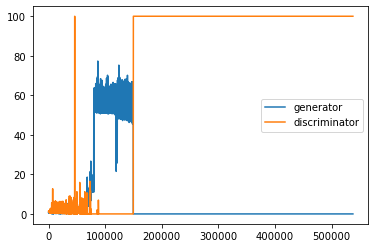

In [60]:
plt.plot(G_losses, label='generator')
plt.plot(D_losses, label='discriminator')
plt.legend()